In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from matplotlib import font_manager, rc
import sqlite3
import urllib
import seaborn as sns
from scipy.stats import binom
import warnings

In [2]:
# 환경설정
#pd.options.display.float_format = '{:,.0f}'.format
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
# 상품정보
prd_info = pd.read_excel('V40.xlsx', sheet_name='상품정보')
prd_info['상품코드'] = prd_info['상품코드'].astype(object)
prd_info['출시일'] = prd_info['출시일'].astype(str)
prd_info['용량'] = prd_info['용량'].astype(str)

In [4]:
# SQL DB 생성 및 상품정보 적재
conn = sqlite3.connect('LG_phone.db')
cur = conn.cursor()

#cur.execute('create table 상품정보(상품코드, 상품명, 모델명, 용량, 통신사, 출시일, 시리즈)')
#cur.execute('create table 중고가(상품코드, 기준일자, 최저, 중간, 최고)')
#cur.execute('create table 출고가(상품코드, 기준일자, 출고가)')

#sql = 'insert into 상품정보 values (?,?,?,?,?,?,?)'
#cur.executemany(sql, [tuple(prd_info.iloc[i]) for i in range(len(prd_info))])
#conn.commit()

In [5]:
# 출고가 적재
# sql = 'select 상품코드 from 상품정보'
# cur.execute(sql)
# pno = [cd[0] for cd in cur.fetchall()]

# for pl in pno:
#     params = {'act':'factory_price','q':'info', 'pno':pl}
#     url = 'https://market.cetizen.com/market.php'
#     url_params = '{}?{}'.format(url, urllib.parse.urlencode(params))
#     html = urllib.request.urlopen(url_params).read().decode('ansi')
    
#     soup = BeautifulSoup(html, 'html.parser')
    
#     txt = soup.find_all('script',{'type':"text/javascript"})[18].text
#     start = txt.find('[')
#     end = txt.find(']')
#     txt = txt[start:end+1].replace('\r\n\t','').replace('date','"date"').replace('value','"value"').replace(': }',':None}')
#     data = eval(txt)
#     #print(pl, data[0])
    
#     sql = 'insert into 출고가 values (?,?,?)'
#     cur.executemany(sql, list(map(lambda dt:(pl, dt['date'], dt['value']), data)))

# conn.commit()
# print('-- Done --')

In [6]:
# # 중고가 적재
# sql = 'select 상품코드 from 상품정보'
# cur.execute(sql)
# pno = [cd[0] for cd in cur.fetchall()]

# for pl in pno:
#     params = {'q':'info', 'pno':pl}
#     url = 'https://market.cetizen.com/market.php'
#     url_params = '{}?{}'.format(url, urllib.parse.urlencode(params))
#     html = urllib.request.urlopen(url_params).read().decode('ansi')
#     soup = BeautifulSoup(html, 'html.parser')
#     txt = soup.find_all('script',{'type':"text/javascript"})[18].text
#     start = txt.find('[')
#     end = txt.find(']')
#     txt = txt[start:end+1].replace('\r\n\t','').replace('date','"date"').replace('mid','"mid"').replace('high','"high"').replace('low','"low"')
#     data = eval(txt)
#     #print(pl, data[0])
#     sql = 'insert into 중고가 values (?,?,?,?,?)'
#     cur.executemany(sql, list(map(lambda dt:(pl, dt['date'], dt['low'], dt['mid'], dt['high']), data)))

# conn.commit()
# print('-- Done --')

In [7]:
# 상품정보 데이터 프레임으로 변환
cur.execute("select * from 상품정보 where 시리즈 != 'Q'")
rows = cur.fetchall()
prd_info = pd.DataFrame(rows, columns=['상품코드', '상품명', '모델명', '용량', '통신사', '출시일', '시리즈'])

# 중고가 데이터 프레임으로 변환
cur.execute('select * from 중고가')
rows = cur.fetchall()
prd_price = pd.DataFrame(rows, columns=['상품코드', '기준일자', '최저', '중간', '최고'])
prd_price[['최저','중간','최고']] = prd_price[['최저','중간','최고']].astype(float)
prd_price = prd_price.merge(prd_info, on='상품코드', how='left')
prd_price['기준일자'] = pd.to_datetime(prd_price['기준일자'])
prd_price['출시일'] = pd.to_datetime(prd_price['출시일'])
prd_price['경과일자'] = prd_price['기준일자'] - prd_price['출시일']
prd_price['경과일자'] = prd_price['경과일자'].apply(lambda x:x.days)

# 출고가 데이터 프레임으로 변환
cur.execute('select * from 출고가')
rows = cur.fetchall()
rel_price = pd.DataFrame(rows, columns=['상품코드', '기준일자', '출고가'])
rel_price_grp = rel_price.groupby('상품코드')[['출고가']].max().reset_index()

# 출고가 데이터와 중고가 데이터 합치기
prd_price = prd_price.merge(rel_price_grp, on='상품코드', how='inner')
prd_price.eval('출고가대비 = 최저/출고가*100', inplace=True)

# V시리즈만 골라내기 & 800일 이전 데이터만 사용
prd_price_v = prd_price.query('시리즈 == "V"').query('경과일자 < 800')

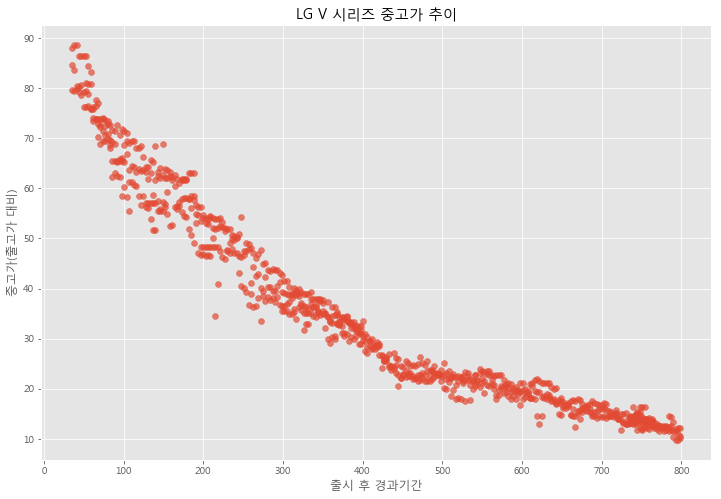

In [8]:
# 데이터 시각화
plt.figure(figsize=(12,8))
plt.scatter(prd_price_v['경과일자'], prd_price_v['출고가대비'], alpha=0.7)
plt.title('LG V 시리즈 중고가 추이')
plt.xlabel('출시 후 경과기간')
plt.ylabel('중고가(출고가 대비)')
plt.show()

In [9]:
# 회귀분석
import statsmodels.api as sm

X = np.array(prd_price_v['경과일자']).reshape(-1,1)
X = np.concatenate([X,X**2], axis=1)
X = sm.add_constant(X)
y = np.array(np.log(prd_price_v['출고가대비'])).reshape(-1,1)

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 2.125e+04
Date:                Thu, 18 Oct 2018   Prob (F-statistic):               0.00
Time:                        18:22:24   Log-Likelihood:                 954.12
No. Observations:                 873   AIC:                            -1902.
Df Residuals:                     870   BIC:                            -1888.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5249      0.010    472.396      0.000       4.506       4.544
x1            -0.0031   5.31e-05    -58.143      0.000      -0.003      -0.003
x2          7.001e-07   6.16e-08     11.357      0.000    5.79e-07    8.21e-07
==============================================================================
Omnibus:                       32.543   Durbin-Watson:                   0.459
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.087
Skew:                          -0.417   Prob(JB):                     5.37e-09
Kurtosis:                       3.592   Cond. No.                     1.03e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

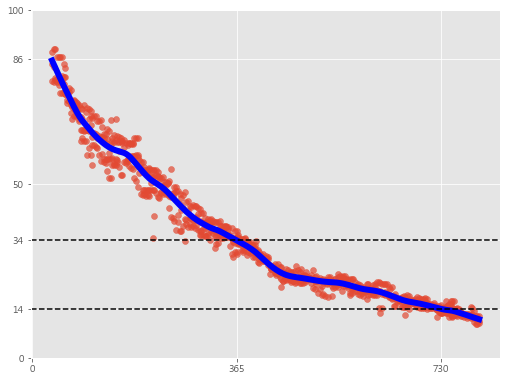

In [10]:
# 결과 시각화(2)
time = np.arange(0,800).reshape(-1,1)
time = np.concatenate([time,time**2], axis=1)
time = sm.add_constant(time)
lowess = sm.nonparametric.lowess
w = lowess(np.log(prd_price_v['출고가대비']), prd_price_v['경과일자'], frac=0.1)

sc = 0.9
plt.figure(figsize=(8*sc, 6*sc))
plt.scatter(prd_price_v['경과일자'], prd_price_v['출고가대비'], alpha=0.7)
#plt.title('LG V 시리즈 중고가 추이')
#plt.xlabel('출시 후 경과기간')
#plt.ylabel('중고가(출고가 대비)')
plt.plot(w[:,0], np.exp(w[:,1]), lw=6, c='blue', alpha=1)
plt.xticks([0,365,365*2])
plt.yticks([0,14,34,50,86,100])
plt.axhline(y=14, c='black', linestyle='dashed')
plt.axhline(y=34, c='black', linestyle='dashed')
plt.tight_layout()
plt.savefig('V시리즈_중고가추이')
plt.show()

In [11]:
# 가정 설정
mat = 730
mu = results.predict([1,mat,mat**2])[0]
sigma = np.sqrt(results.mse_resid)
asset_value = 1099000
policies = 1900
premium = 9500
expenses = 33290 + 400
lapse = np.array([0.0254,0.0371,0.0213,0.0173,0.0138,0.0129,0.0176,0.0152,0.0128,0.0139,0.0150,0.0173,
                  0.0184,0.0164,0.0171,0.0175,0.0192,0.0185,0.0234,0.0250,0.0279,0.0262,0.0304,0.0338])
lapse_lv = 1
sum_insured = 0.4
exercise = 0.5
discount = 0.5

# 계산
retention = np.cumprod(1-lapse*lapse_lv)
total_premium = np.sum(retention*premium)*policies

# 2년 후 잔존율 예측 범위
np.exp(mu-sigma), np.exp(mu+sigma)

(12.957349545357573, 15.243865165875624)

In [ ]:
# 시뮬레이션
np.random.seed(20181018)
num = 100000
simulation = []
for i in range(num):
    freq = binom.rvs(n=policies, p=retention[-1]*exercise)
    resid_values = np.random.lognormal(mean=mu, sigma=sigma, size=freq)*(1-discount)/100
    loss = np.fmax(asset_value*(sum_insured-resid_values)+expenses,0)
    total_loss = np.sum(loss)
    simulation.append(total_loss)

In [20]:
# 민감도 분석 (1)
def Sensitivity(lapse_lv, exercise, discount):
    np.random.seed(20181018)
    retention = np.cumprod(1-lapse*lapse_lv)
    total_premium = np.sum(retention*premium)*policies
    num = 100000
    simulation = []
    for _ in range(num):
        freq = binom.rvs(n=policies, p=retention[-1]*exercise)
        resid_values = np.random.lognormal(mean=mu, sigma=sigma, size=freq)*(1-discount)/100
        loss = np.fmax(asset_value*(sum_insured-resid_values)+expenses,0)
        total_loss = np.sum(loss)
        simulation.append(total_loss)
    loss_ratio = np.mean(simulation)/total_premium
    return loss_ratio

In [ ]:
# 민감도 분석 (2)
stress = []
for lapse_lv in np.arange(0.5,1.5001,0.1):
    for exercise in np.arange(0.1,0.7001,0.1):
        for discount in np.arange(0.2,0.8001,0.1):
            stress.append([lapse_lv, exercise, discount, Sensitivity(lapse_lv,exercise,discount)])
stress = pd.DataFrame(stress, columns=['해지율수준','만기시행사율','매각가율','손해율'])

In [ ]:
# 민감도분석 결과 저장
writer = pd.ExcelWriter('민감도분석.xlsx', 'xlsxwriter')
stress.to_excel(writer, index=False)
writer.save()
writer.close()